In [1]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

In [37]:
with open("intermediates/segregation_by_month_parallel.pickle", "rb") as pickleFile:
    output = pickle.load(pickleFile)

In [38]:
with open("intermediates/station_networks_by_month.pickle", "rb") as pickleFile:
    networks = pickle.load(pickleFile)
    for year in networks:
        for month in networks[year]:
            G = networks[year][month]
            G = nx.DiGraph(G.subgraph(max(nx.weakly_connected_components(G), key = len)))
#             print("Year: {} Month: {} Size: {}".format(year,
#                                                       month,
#                                                       len(G)))

In [39]:
def get_mu(C_s, C_s_null, step_size):
    n = int(1 / step_size) + 1
    mu = np.array([np.mean([C[i] for C in C_s]) for i in range(n)])
    mu_null = np.array([np.mean([C[i] for C in C_s_null]) for i in range(n)])
    return step_size * np.sum(np.abs(mu - mu_null))

def get_sigma(C_s, C_s_null, step_size):
    n = int(1 / step_size) + 1
    mu = np.array([max(np.mean([C[i] for C in C_s]), 0.001) for i in range(n)])
    mu_null = np.array([max(np.mean([C[i] for C in C_s_null]), 0.001) for i in range(n)])
    
    std = np.array([np.std([C[i] for C in C_s]) for i in range(n)])
    std_null = np.array([np.std([C[i] for C in C_s_null]) for i in range(n)])
    return step_size * np.sum(np.abs((std / mu) - (std_null / mu_null)))

def get_coef_variation(C_s, C_s_null, G, step_size = 0.001):
    n = int(1 / step_size) + 1
    edge_sums = np.zeros(n)
    edge_sums_null = np.zeros(n)
    nodes = list(G.nodes())
    node_to_idx = {nodes[i]: i for i in range(len(nodes))}
    
    total_weight = 0
    for node_i, node_j in G.edges():
        i_idx = node_to_idx[node_i]
        j_idx = node_to_idx[node_j]
        weight = G[node_i][node_j]["weight"]
        total_weight += weight
        for step_idx in range(n):
            edge_sums[step_idx] += weight * abs(C_s[i_idx][step_idx] - C_s[j_idx][step_idx])
            edge_sums_null[step_idx] += weight * abs(C_s_null[i_idx][step_idx] - C_s_null[j_idx][step_idx])
        
    edge_sums /= total_weight
    edge_sums_null /= total_weight
    
    return step_size * np.sum(np.abs(edge_sums - edge_sums_null))

In [53]:
G = networks[2018][7]
for node in G:
    print(G.nodes[node])

{'station_id': '149'}
{'station_id': '1'}
{'station_id': '116'}
{'station_id': '158'}
{'station_id': '214'}
{'station_id': '183'}
{'station_id': '142'}
{'station_id': '66'}
{'station_id': '107'}
{'station_id': '113'}
{'station_id': '20'}
{'station_id': '35'}
{'station_id': '236'}
{'station_id': '10'}
{'station_id': '16'}
{'station_id': '58'}
{'station_id': '53'}
{'station_id': '82'}
{'station_id': '79'}
{'station_id': '210'}
{'station_id': '117'}
{'station_id': '23'}
{'station_id': '65'}
{'station_id': '219'}
{'station_id': '13'}
{'station_id': '205'}
{'station_id': '42'}
{'station_id': '50'}
{'station_id': '134'}
{'station_id': '61'}
{'station_id': '55'}
{'station_id': '30'}
{'station_id': '175'}
{'station_id': '15'}
{'station_id': '194'}
{'station_id': '234'}
{'station_id': '193'}
{'station_id': '86'}
{'station_id': '171'}
{'station_id': '122'}
{'station_id': '225'}
{'station_id': '96'}
{'station_id': '95'}
{'station_id': '6'}
{'station_id': '84'}
{'station_id': '76'}
{'station_id': 

In [64]:
df = []
random_walk_length = []
for year in output:
    print(year)
    for month in output[year]:
        print(month)
        G = networks[year][month]
        G = nx.DiGraph(G.subgraph(max(nx.weakly_connected_components(G), key = len)))

        for node_i in G:
            total_trips = np.sum([G[node_i][node_j]["weight"] for node_j in G.neighbors(node_i)])
            for node_j in G.neighbors(node_i):
                G[node_i][node_j]["weight"] /= total_trips
        assert len(G) == len(output[year][month]["C_s"])
        assert len(G) == len(output[year][month]["C_s_null"])

#         output[year][month]["Coefficient of Variation"] = get_coef_variation(output[year][month]["C_s"],
#                                                                             output[year][month]["C_s_null"],
#                                                                             G)
#         if month == 7:
        nodes = list(G.nodes())
        for i in range(len(nodes)):
            if "station_id" in G.nodes[nodes[i]]:
                random_walk_length.append({
                    "Date": datetime(year, month, 1),
                    "Station Name": nodes[i],
                    "Station Id": G.nodes[nodes[i]]["station_id"],
                    "Steps": output[year][month]["C_s"][i][-1],
                    "Steps Null": output[year][month]["C_s_null"][i][-1]
                })
            else:
                print("Node id for station: {}".format(nodes[i]))
                
        df.append(output[year][month])
df = pd.DataFrame(df)
df = df.set_index("Date")

random_walk_length_df = pd.DataFrame(random_walk_length)

2015
1
Node id for station: Boston Public Library - 700 Boylston St.
Node id for station: Kenmore Sq / Comm Ave
Node id for station: Landmark Centre
Node id for station: Aquarium Station - 200 Atlantic Ave.
Node id for station: Christian Science Plaza
Node id for station: Longwood Ave / Binney St
Node id for station: Spaulding Rehabilitation Hospital - Charlestown Navy Yard
Node id for station: Harvard University Transportation Services - 175 North Harvard St
Node id for station: HMS / HSPH - Ave. Louis Pasteur at Longwood Ave.
Node id for station: Prudential Center / Belvidere
Node id for station: Harvard Real Estate - Brighton Mills - 370 Western Ave
Node id for station: Innovation Lab - 125 Western Ave. at Batten Way
Node id for station: Back Bay / South End Station
Node id for station: Charlestown - Warren St at Chelsea St
Node id for station: Harvard University Housing - 111 Western Ave. at Soldiers Field Park 
Node id for station: Boylston St. at Arlington St.
Node id for station

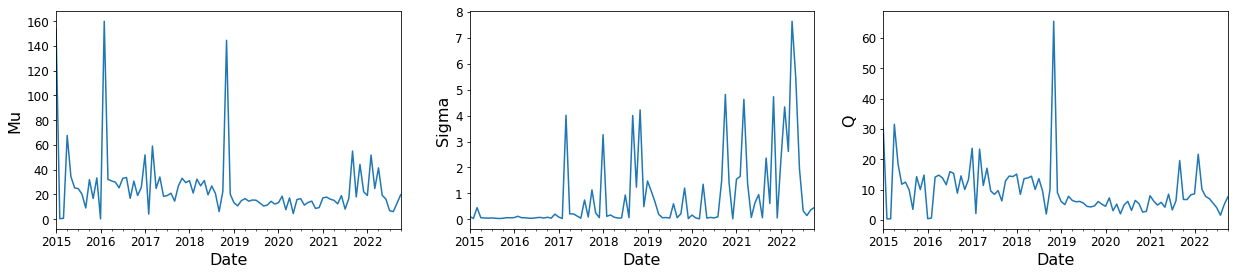

In [35]:
fig, axs = plt.subplots(ncols = 3, figsize=(7 * 3, 4))

plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

df["Mu"].plot(ax = axs[0])
axs[0].set_ylabel("Mu")

df["Sigma"].plot(ax = axs[1])
axs[1].set_ylabel("Sigma")

df["Coefficient of Variation"].plot(ax = axs[2])
axs[2].set_ylabel("Q")

plt.savefig("figs/segregation_over_time.pdf", bbox_inches = "tight")

In [36]:
df.to_csv("temp/segregation_metrics.csv")

In [ ]:
df["Number of Sinks"] = [len(sinks) for sinks in df["Sinks"]]
df["Number of Sinks"].plot()
sink_counts = {}
for dt in df.index:
    if dt.month == 1:
        continue
    sinks = df.loc[dt]["Sinks"]
    for sink in sinks:
        if sink not in sink_counts:
            sink_counts[sink] = 0
        sink_counts[sink] += 1
sorted(sink_counts.items(), key=lambda item : item[1], reverse = True)

In [ ]:
df["Number of Incomplete Nodes"] = [len(incompletes) for incompletes in df["Incomplete Nodes"]]
df["Number of Incomplete Nodes"].plot()
incomplete_counts = {}
for dt in df.index:
    if dt.month == 1:
        continue
    incompletes = df.loc[dt]["Incomplete Nodes"]
    for incomplete in incompletes:
        if incomplete not in incomplete_counts:
            incomplete_counts[incomplete] = 0
        incomplete_counts[incomplete] += 1
sorted(incomplete_counts.items(), key=lambda item : item[1], reverse = True)

In [65]:
station_races = pd.read_csv("temp/station_races.csv")[["id", "Lat", "Long", "Race"]]
station_races["id"] = [str(station_id) for station_id in station_races["id"]]
station_races = station_races.set_index("id")
random_walk_length_df = random_walk_length_df.join(station_races, on = "Station Id")

In [67]:
random_walk_length_df.to_csv("temp/random_walk_lengths.csv")

In [3]:
random_walk_length_df = pd.read_csv("temp/random_walk_lengths.csv")

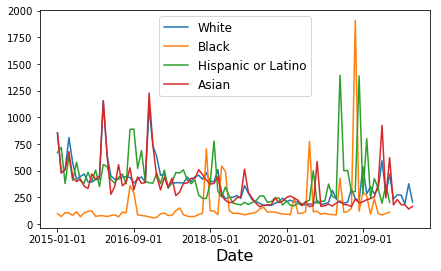

In [21]:
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels

plt.rc('font', size=12)          # controls default text sizes


fig, ax = plt.subplots(figsize=(7,4))
#random_walk_length_df.groupby(["Date"]).mean()["Steps"].plot(ax = ax, label = "total")
for race in ["White", "Black", "Hispanic or Latino", "Asian"]:
    random_walk_length_df[random_walk_length_df["Race"] == race]\
        .groupby(["Date"]).mean()["Steps"].plot(ax = ax, label = race)
ax.legend()
plt.savefig("figs/random_walk_lengths_linechart.pdf", bbox_inches="tight")

In [18]:
for race in ["White", "Black", "Hispanic or Latino", "Asian"]:
    steps_2019 = random_walk_length_df[(random_walk_length_df["Race"] == race) \
                          & [date[:4] == "2019" for date in random_walk_length_df["Date"]]]\
                .groupby("Date").mean()["Steps"]

    steps_2022 = random_walk_length_df[(random_walk_length_df["Race"] == race) \
                          & [date[:4] == "2022" for date in random_walk_length_df["Date"]]]\
                .groupby("Date").mean()["Steps"]
    print("Race: {} 2019 Avg: {} 2021 Avg: {} Increase: {}".format(race,
                                                     np.mean(steps_2019),
                                                     np.mean(steps_2022),
                                                     (np.mean(steps_2022) - np.mean(steps_2019)) / np.mean(steps_2019)))

Race: White 2019 Avg: 225.34594605036895 2021 Avg: 323.7045946955326 Increase: 0.4364784473343873
Race: Black 2019 Avg: 174.72056615295847 2021 Avg: 332.39961642163064 Increase: 0.9024641674445619
Race: Hispanic or Latino 2019 Avg: 234.53981559290386 2021 Avg: 455.7029377835589 Increase: 0.9429662150606145
Race: Asian 2019 Avg: 239.6112082362082 2021 Avg: 324.66763888888886 Increase: 0.3549768446926415
